In [2]:
# import modules
import sys
from os import listdir, path
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xarray as xr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [1]:
!conda install -y pytorch==2.0.1 torchvision==0.15.2 pytorch-cuda=11.7 -c pytorch -c nvidia
!pip install xarray

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch-cuda=11.7
    - pytorch==2.0.1
    - torchvision==0.15.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |   py38h06a4308_0         153 KB
    conda-4.12.0               |   py38h06a4308_0        14.5 MB
    cuda-cudart-11.7.99        |                0         194 KB  nvidia
    cuda-cupti-11.7.101        |                0        22.9 MB  nvidia
    cuda-libraries-11.7.1      |                0           1 KB  nvidia
    cuda-nvrtc-11.7.99         |                0        17.3 MB  nvidia
    cuda-nvtx-11.7.91          |                0          57 KB  nvidia
    cuda-runtime-11.7.1       

In [3]:
torch.version.cuda

'11.7'

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
# constnats
AREA_WIDTH  = 17000
AREA_HIGHT = 3500

BLOCK_WIDTH  = 400
BLOCK_HEIGHT = 100

NUMBER_OF_SAMPLE = 301#401
NUMBER_OF_RECEIVERS = 341#401

Nx = 341
Ny = 351

dx = AREA_WIDTH / (Nx-1)
dy = AREA_HIGHT / (Ny-1)

In [27]:
print(f'Grid steps dx : {dx}, dy : {dy}')
nx, ny = int(BLOCK_WIDTH/dx), int(BLOCK_HEIGHT/dy)
print(f'Block size in nodes : ({nx}, {ny})')

Grid steps dx : 50.0, dy : 10.0
Block size in nodes : (8, 10)


## Prepare dataset

In [28]:
## read empty signal
import struct

X_empty = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
with open('seismogram.bin', 'rb') as fd :
    for i in range(NUMBER_OF_SAMPLE):
        ts = struct.unpack('d', fd.read(8))
        tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
        if(tmp.size == 0):
            break
        X_empty[0, i, :] = tmp[::2] #vx
        X_empty[1, i, :] = tmp[1::2] #vy

In [29]:
import struct

dir = "./dataset_mixed/vtk/"
# seismograms
X = {}
# target boxes
y = {}
# scalars
y_s = {}

mask = np.zeros((Ny, Nx), dtype='bool')

# read signals
for file in listdir(dir):
    with open(dir+file, 'rb') as fd :
        str = file.split('_')
        x0 = int(int(str[1])/dx)
        y0 = int(int(str[2])/dy)
        y_sc = float(int(str[3][:str[3].find('.')]))

        signal = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
        for i in range(NUMBER_OF_SAMPLE):
            ts = struct.unpack('d', fd.read(8))
            tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
            if(tmp.size == 0):
                break
            signal[0, i, :] = tmp[::2] #- X_empty[0, i, :]#vx
            signal[1, i, :] = tmp[1::2] #- X_empty[1, i, :]#vy

        key = (x0, y0)

        if (key in X.keys()):
            X[key].append(signal)
            y[key].append(np.copy(mask))
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key].append(y_sc)
        else:
            X[key] = [signal]
            y[key] = [np.copy(mask)]
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key] = [y_sc]

In [9]:
# train.test split
import random

test_size = 0.2

keys = list(X.keys())
random.shuffle(keys)
ind_split = int(len(keys) * test_size)

test_keys = keys[0:ind_split]
train_keys = keys[ind_split:-1]

X_test, y_test, y_s_test = [], [], []
for key in test_keys:
    for X_el, y_el, y_s_el in zip(X[key], y[key], y_s[key]):
        X_test.append(X_el)
        y_test.append(y_el)
        y_s_test.append(y_s_el)

X_train, y_train, y_s_train = [], [], []
for key in train_keys:
    for X_el, y_el, y_s_el in zip(X[key], y[key], y_s[key]):
        X_train.append(X_el)
        y_train.append(y_el)
        y_s_train.append(y_s_el)

In [10]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torchvision.transforms import Resize

resize = Resize((Ny, Nx))

class SeismicDataset(Dataset):
    def __init__(self, X, y, y_s, transform=resize):
        self.transform=transform
        self.X = deepcopy(X)
        self.y = deepcopy(y)
        self.y_s = deepcopy(y_s)
        # augmentation
        for x in X:
            self.X.append(x[:, :, ::-1])
        for y_el in y:
            self.y.append(y_el[:, ::-1])
        for y_el in y_s:
            self.y_s.append(y_el)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(self.X[idx].shape)
        X_out = torch.tensor(self.X[idx].copy())
        return  self.transform(X_out), torch.tensor(self.y[idx].copy()), torch.tensor(self.y_s[idx])

batch_size = 16

train_dataset = SeismicDataset(X_train, y_train, y_s_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeismicDataset(X_test, y_test, y_s_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

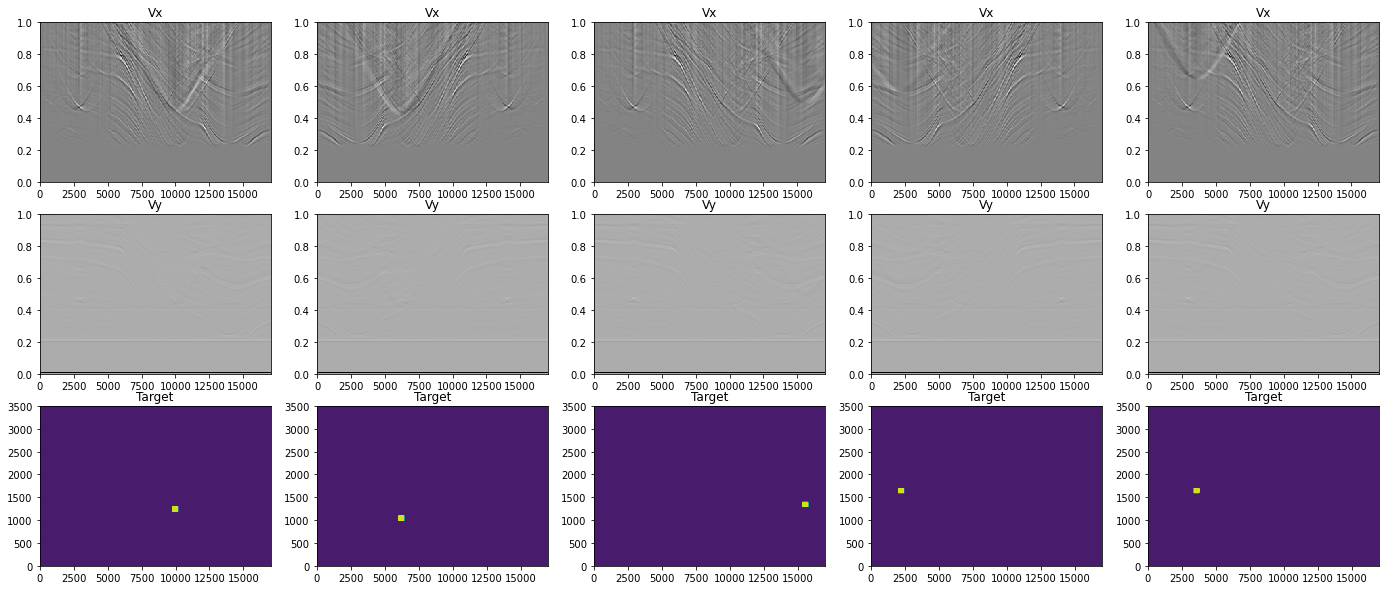

In [11]:
from matplotlib.pyplot import cm

X_1, y_1, y_s_1 = next(iter(train_dataloader))

x = np.linspace(0, AREA_WIDTH, Nx)
t = np.linspace(0, 1, Ny)

fig, ax = plt.subplots(3, 5, figsize = (24, 10))

for i in range(5):
    ax[0, i].pcolormesh(x, t, X_1[i, 0, :], cmap=cm.gray)
    ax[0, i].set_title('Vx')
    ax[1, i].pcolormesh(x, t, X_1[i, 1, :], cmap=cm.gray)
    ax[1, i].set_title('Vy')
    ax[2, i].set_title('Target')
    ax[2, i].contourf(x, t*AREA_HIGHT, y_1[i, :])

plt.show()

### Default U-net architecture

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode, size=None):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            if size == None:
                self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            else :
                self.up_sample = nn.Upsample(size = size, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_classes=1, up_sample_mode='bilinear'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode, size = (43, 42))
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode, size = (87, 85))
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode, size = (175, 170))
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode, size = (351, 341))
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [13]:
from torch.nn import BCEWithLogitsLoss

class Loss_Metrics_Mem(object):
    
    def __init__(self):
        super().__init__()
        self.loss = None
        self.loss_h = []
        self.val_loss_h = []
        self.metrics_h = []
        
    def upd_loss(self, loss_val):
        if self.loss is None:
             self.loss = loss_val
        else:
             self.loss = self.loss + loss_val
    def clean_loss(self):
        self.loss = None
            
    def upd_metrics(self, loss_val, metrics_val):
        self.val_loss_h.append(loss_val)
        self.metrics_h.append(metrics_val)
        self.loss_h.append(self.loss)
        
    def plot(self, axes):
        xlen = len(self.loss_h)
        axes[0].plot(range(xlen), self.loss_h, label='train')
        axes[0].plot(range(xlen), self.val_loss_h, label='test')
        axes[0].legend()
        axes[1].plot(range(xlen), self.metrics_h, label='test')

## Weighted binary cross-entropy loss

В силу несбланасированности задачи (размер кластера много меньше размера области) необходимо ввести дополниетльный вес для положительной метки. Этот вес подбирался как доля площади так и линейная доля горизонтального растояния (по оси X). Последняя нормировка показала себя лучше в ходе обучения

In [14]:
## weight for loss
#weight_bce = 1 / (torch.sum(y_1[0, :, :]) / Nx/ Ny) / 2
weight_bce = torch.tensor(AREA_WIDTH / BLOCK_WIDTH) / 2
print(weight_bce)

tensor(21.2500)


In [60]:
model = UNet(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-5)
mae_loss = nn.MSELoss()
l_m = Loss_Metrics_Mem()
Loss = BCEWithLogitsLoss(pos_weight=weight_bce)

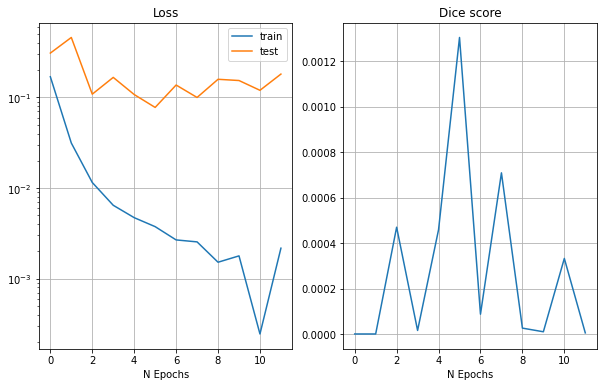

0.18108745591532915 4.706257572990608e-06


KeyboardInterrupt: 

In [61]:
N_epochs = 25

for epoch in range(N_epochs):
    
    model.train()
    for X, y, _ in train_dataloader:
        # X = X[:, 1, :, :].float().unsqueeze(1)
        X = X.float()
        y = y.squeeze()
        y_pred = model(X.to(device)).squeeze()
        loss = Loss(y_pred.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m.upd_loss(loss.item() * y.shape[0] / len(train_dataset))
    model.eval()
    loss_val = 0
    dice_score = 0;
    with torch.no_grad():
        for X,  y, _ in test_dataloader:
            #X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y = y.squeeze()
            y_pred = model(X.to(device)).squeeze()
            loss = Loss(y_pred.float(), y.to(device).float())
            #mask = (y_pred.to('cpu') > 0) == y
            loss_val += loss.item() * y.shape[0] / len(test_dataset)
            #dice_score += torch.sum( 
            #    2 * torch.sum(y*mask, axis = (1, 2)) / (
            #    torch.sum(y, axis = (1, 2)) \
            #    + torch.sum((y_pred.to('cpu') > 0), axis = (1, 2))) ,
            #    axis=0).item() / len(test_dataset)
            y_pred = torch.sigmoid(y_pred).to('cpu')
            nominator = 2 * \
                torch.sum(y_pred * y, axis=(1, 2))
            denominator = torch.sum(y_pred , axis= (1, 2)) \
                      + torch.sum(y, axis= (1, 2))
            dice_score += torch.sum(nominator / denominator).item() / len(test_dataset)

    l_m.upd_metrics(loss_val, 
                        dice_score)

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_title('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_title('Dice score')
    l_m.plot(axes)
    plt.show()
    
    print(l_m.val_loss_h[-1], l_m.metrics_h[-1])

    l_m.clean_loss()

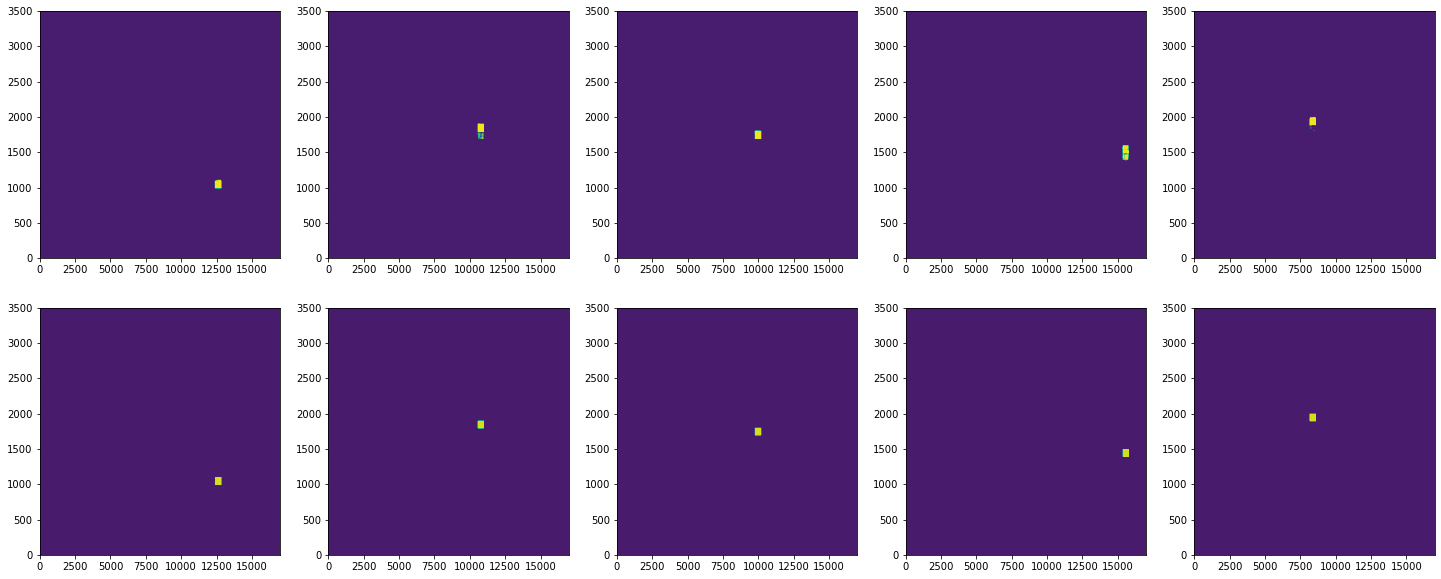

In [65]:
X, y, _ = next(iter(test_dataloader))

fig, ax = plt.subplots(2, 5, figsize = (25, 10))

y_pred = model(X.float().to(device)).squeeze().to('cpu').detach()

for i in range(5):
    ax[0, i].contourf(x, t * AREA_HIGHT, torch.sigmoid(y_pred[5+i, :]).numpy(), vmin=0, vmax=1)
    ax[1, i].contourf(x, t * AREA_HIGHT, y[5+i, :].numpy())

In [39]:
torch.save(model.state_dict(), 'BSE_vxvy.pt')

Результат предскзаания внешне кажется приемлимым, ошибка (вероятно) в Dcie score

## Dice loss

$$
DiceLoss(y, \hat{y}) = 1 - \frac{2 ||y \cap \hat{y}||}{||y||+||\hat{y}||}
$$

In [66]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6, gama=1):
        super(DiceLoss,self).__init__()
        self.smooth = smooth
        self.gama = gama

    def forward(self, y_true, y_pred):
        nominator = 2 * \
            torch.sum(y_pred * y_true, axis=(1, 2)) + self.smooth
        denominator = torch.sum(y_pred ** self.gama, axis= (1, 2)) \
                      + torch.sum(y_true ** self.gama, axis= (1, 2)) + self.smooth
        result = 1 - nominator / denominator
        return torch.sum(result) / torch.numel(result)

In [67]:
model = UNet(in_channels=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.25e-4, weight_decay=5e-5)
mae_loss = nn.MSELoss()
l_m = Loss_Metrics_Mem()
Loss = DiceLoss()

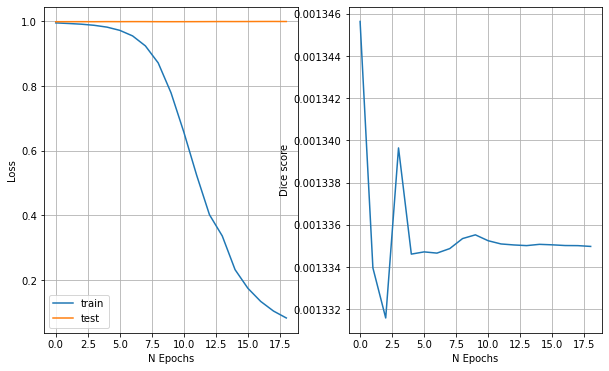

0.9992276350955913 0.001334973644782651


KeyboardInterrupt: 

In [68]:
N_epochs = 50

for epoch in range(N_epochs):
    
    model.train()
    for X, y, _ in train_dataloader:
        #X = X[:, 1, :, :].float().unsqueeze(1)
        X = X.float()
        y_pred = torch.sigmoid(model(X.to(device)).squeeze())
        loss = Loss(y_pred.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m.upd_loss(loss.item() * y.shape[0] / len(train_dataset))
    model.eval()
    loss_val = 0
    dice_score = 0;
    with torch.no_grad():
        for X,  y, _ in test_dataloader:
            #X = X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y_pred = torch.sigmoid(model(X.to(device)).squeeze())
            loss = Loss(y_pred.float(), y.to(device).float())
            mask = (y_pred.to('cpu') > 0.5) == y
            loss_val += loss.item() * y_pred.shape[0] / len(test_dataset)
            y_pred = torch.sigmoid(y_pred).to('cpu')
            nominator = 2 * \
                torch.sum(y_pred * y, axis=(1, 2))
            denominator = torch.sum(y_pred , axis= (1, 2)) \
                      + torch.sum(y, axis= (1, 2))
            dice_score += torch.sum(nominator / denominator).item() / len(test_dataset)

    l_m.upd_metrics(loss_val, 
                        dice_score)

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].set_ylabel('Loss')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_ylabel('Dice score')
    axes[0].grid()
    axes[1].grid()
    l_m.plot(axes)
    plt.show()
    
    print(l_m.val_loss_h[-1], l_m.metrics_h[-1])

    l_m.clean_loss()

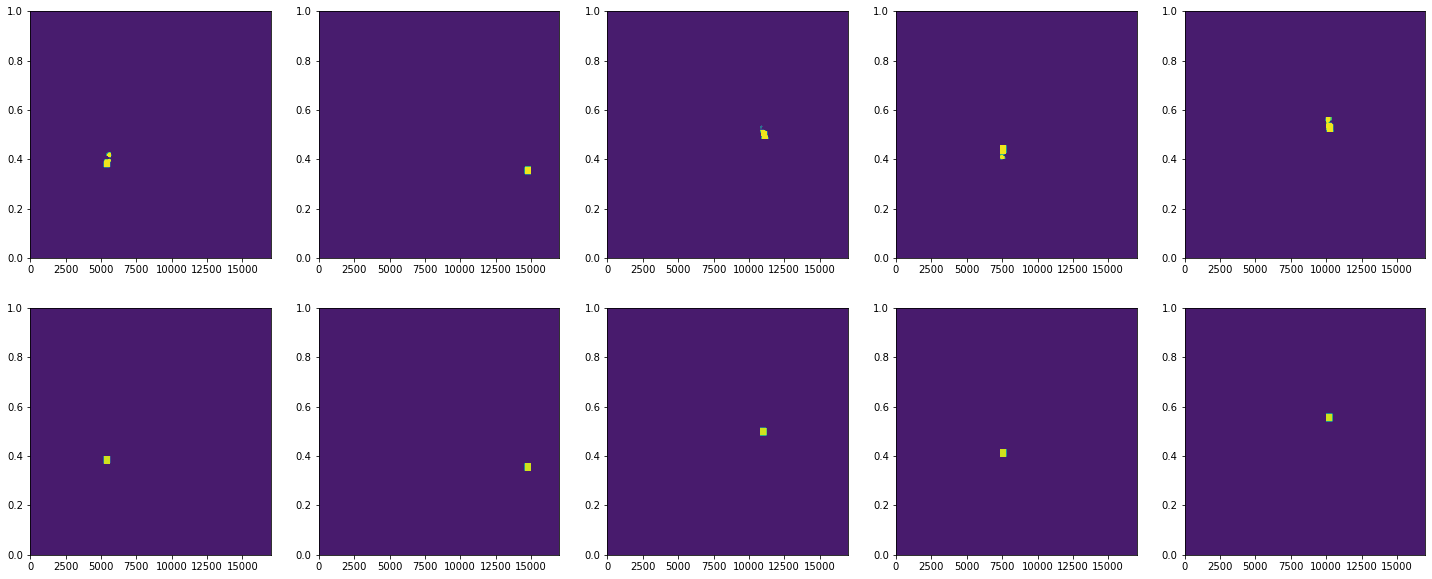

In [74]:
X, y, _ = next(iter(test_dataloader))

fig, ax = plt.subplots(2, 5, figsize = (25, 10))

y_pred = model(X.float().to(device)).squeeze().to('cpu').detach()

for i in range(5):
    ax[0, i].contourf(x, t, torch.sigmoid(y_pred[i, :]).numpy(), vmin=0, vmax=1)
    ax[1, i].contourf(x, t, y[i, :].numpy())

In [73]:
torch.save(model.state_dict(), 'Dice_vxvy.pt')

## Scalar prediction